# Projet : Analyse des données de couverture végétale par satellite

## Introduction 

Dans ce projet, nous allons analyser les données de couverture végétale collectées par des satellites pour la zone de Barro Alto. L'objectif principal est d'explorer l'évolution temporelle de la couverture végétale.

## étapes du projet 

- Chargement et exploration des données de couverture végétale (FCOVER) et des paramètres associés (RVI, DLAT, DLON).
- Analyse exploratoire des données pour comprendre leurs distributions et relations.
- Entraînement d'un modèle de régression linéaire pour prédire la couverture végétale.
- Évaluation des performances du modèle à l'aide de l'erreur quadratique moyenne (RMSE).
- Visualisation des prédictions du modèle et des valeurs réelles de la couverture végétale sur un graphe.

### Début 

### Configuration & extraction de données

On importe les bibliothèques nécessaires ainsi que le module `satellite` du cours. 
 
Pour que cela fonctionne correctement, il est nécessaire de créer un environnement virtuel avec toutes les dépendances requises pour le module satellite.

Pour ce faire, on écrit sur le terminal les commandes suivantes.

<pre class="hljs" style="background-color: black; color: c;">
# Créer un environnement virtuel nommé satellite_env

>>>python -m venv satellite_env

# Activer environnement virtuel

>>>satellite_env\Scripts\activate

# Installer les dépendances à partir du fichier requirements.txt
>>>pip install -r requirements.txt

Le fichier `.txt` contiendra les noms des dépendances nécessaires de `satellite`.

On importe les modules.

In [7]:
# Importation des bibliothèques nécessaires
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy.interpolate import griddata

# Importation de satellite
import sys
sys.path.append('/Users/yacinebenami/Desktop/MACS2/Analyse_donnees_macs2')
import satellite as sat
from satellite import Ocli

Le code suivant définit le chemin d'accès aux données. La variable `data_dir` est définie pour pointer vers le dossier "zones" (vous la changerez selon l'emplacement de vos dossiers) dans le répertoire du projet "satellite". Ensuite, les données de couverture végétale (FCOVER) et d'indice de végétation régional (RVI) pour la zone "Barro-Alto" sont lues à partir de fichiers CSV spécifiques.

In [8]:
# Utilisation de os.path.expanduser pour convertir ~ en chemin absolu
data_dir = os.path.expanduser('~/Desktop/MACS2/Analyse_donnees_macs2/satellite/data/zones')

# Définition des noms des zones
zones = ["Barro-Alto", "Moatize-Mozambique", "South-Walker-Creek"]

# Lecture des données FCOVER et RVI pour la zone Barro-Alto
zone_name = "Barro-Alto"
fcover_file = os.path.join(data_dir, zone_name, "FCOVERtable.csv")
rvitable_file = os.path.join(data_dir, zone_name, "RVItable.csv")

# Vérifier si les fichiers existent avant de tenter de les lire
if os.path.exists(fcover_file) and os.path.exists(rvitable_file):
    # Affichage des premières lignes pour vérifier la structure des données
    fc_df = pd.read_csv(fcover_file)
    rvi_df = pd.read_csv(rvitable_file)

    # Affichage des premières lignes des données FCOVER
    print("Premières lignes des données FCOVER pour la zone Barro-Alto :")
    print(fc_df.head())

    # Affichage des premières lignes des données RVI
    print("\nPremières lignes des données RVI pour la zone Barro-Alto :")
    print(rvi_df.head())
else:
    print(f"Le fichier {fcover_file} ou {rvitable_file} n'existe pas. Veuillez vérifier les chemins.")

Premières lignes des données FCOVER pour la zone Barro-Alto :
         DATE                                               FILE  REVISION  \
0  2016-01-10  /Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...         9   
1  2016-01-20  /Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...         9   
2  2016-01-31  /Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...         9   
3  2016-02-10  /Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...         9   
4  2016-02-20  /Volumes/JLTD/Sentinel/FCOVER/C0093628/FCOVER3...         9   

     FCOVER      RMSE        PR  
0  0.808591  0.124193  0.821652  
1  0.799199  0.032586  1.000000  
2  0.806481  0.033995  1.000000  
3  0.811652  0.034934  0.998123  
4  0.812406  0.036070  0.999374  

Premières lignes des données RVI pour la zone Barro-Alto :
         DATE       RVI      RMSE  INCIDENCE  ELEVATION  DIRECTION      DLAT  \
0  2019-04-08  2.022880  0.014757  45.177209  39.718881         -1  0.348049   
1  2019-04-13  2.030516  0.020464  32.315486 

On va s'intéresser que à la zone brésilienne.

### Phase d'exploration 

D'abord, nous allons analyser l'évolution du RVI et de la FCOVER pour la zone d'intérêt. Nous examinerons comment ces variables changent au fil du temps.

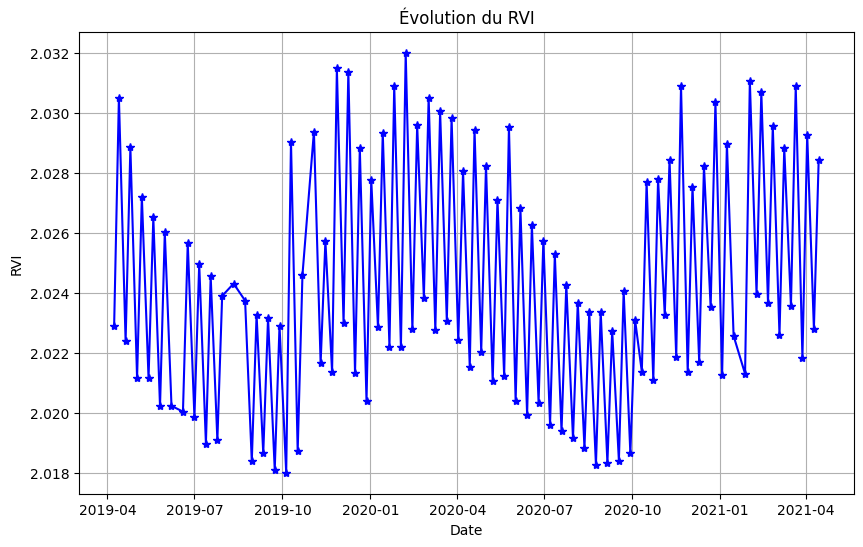

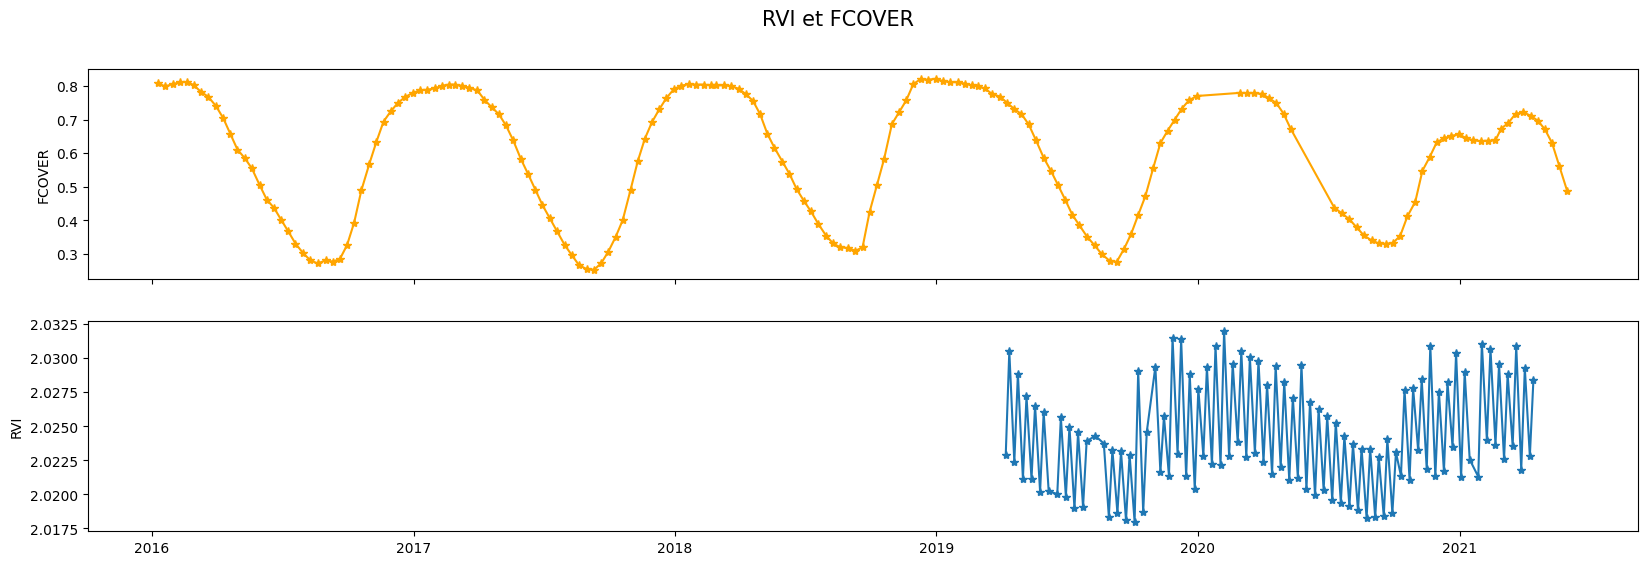

In [9]:
# Convertir la colonne 'DATE' en format de date
rvi_df['DATE'] = pd.to_datetime(rvi_df['DATE'])
fc_df['DATE'] = pd.to_datetime(fc_df['DATE'])
# Tracé de l'évolution du RVI en fonction des dates
plt.figure(figsize=(10, 6))
plt.plot(rvi_df['DATE'], rvi_df['RVI'], linestyle='-', marker='*', color='b')
plt.xlabel('Date')
plt.ylabel('RVI')
plt.title('Évolution du RVI')
plt.grid(True)
plt.show()

# Création d'une figure avec deux sous-graphiques partageant l'axe des abscisses
fig, ax = plt.subplots(2, sharex=True, figsize=(20, 6))

# Tracé de FCOVER en fonction des dates dans le premier sous-graphique
ax[0].plot(fc_df['DATE'], fc_df['FCOVER'], '*-', color="orange")
ax[0].set_ylabel('FCOVER')

# Tracé de RVI en fonction des dates dans le deuxième sous-graphique
ax[1].plot(rvi_df['DATE'], rvi_df['RVI'], '*-')
ax[1].set_ylabel('RVI')

# Titre global pour la figure
fig.suptitle('RVI et FCOVER', fontsize=15)

# Affichage de la figure
plt.show()

Ensuite, on passe à la visualisation de l'évolution de DLAT et DLON au fil du temps. Les données sont affichées dans deux sous-graphiques distincts, l'un montrant DLAT et l'autre montrant DLON.

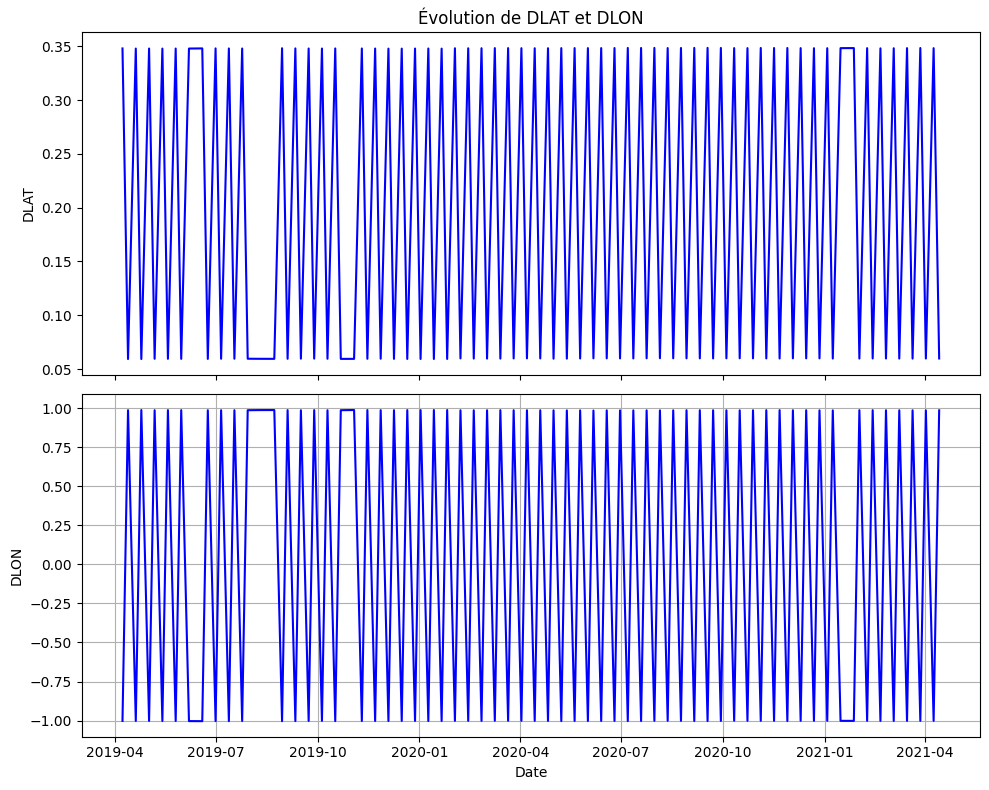

In [10]:
# Création d'une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Tracé de DLAT en fonction des dates
ax1.plot(rvi_df['DATE'], rvi_df['DLAT'], linestyle='-', color='blue')
ax1.set_ylabel('DLAT')
ax1.set_title('Évolution de DLAT et DLON')

# Tracé de DLON en fonction des dates
ax2.plot(rvi_df['DATE'], rvi_df['DLON'], linestyle='-', color='blue')
ax2.set_ylabel('DLON')
ax2.set_xlabel('Date')

plt.grid(True)
plt.tight_layout()
plt.show()

Pour dessiner l'intervalle de confiance, nous utilisons la fonction `fill_between` de Matplotlib. Cette fonction remplit l'espace entre deux courbes. Dans ce cas, nous utilisons les colonnes `RMSE` du DataFrame `fc_df` pour définir la largeur de l'intervalle de confiance. L. Mathématiquement, l'intervalle de confiance est défini comme suit :

$$
\text{Intervalle de confiance} = [\text{FCOVER} - \text{RMSE}, \text{FCOVER} + \text{RMSE}]
$$

Nous avons une marge d'erreur représentée par le RMSE, ce qui nous donne une estimation de la plage dans laquelle se situe la vraie valeur avec un certain niveau de confiance.

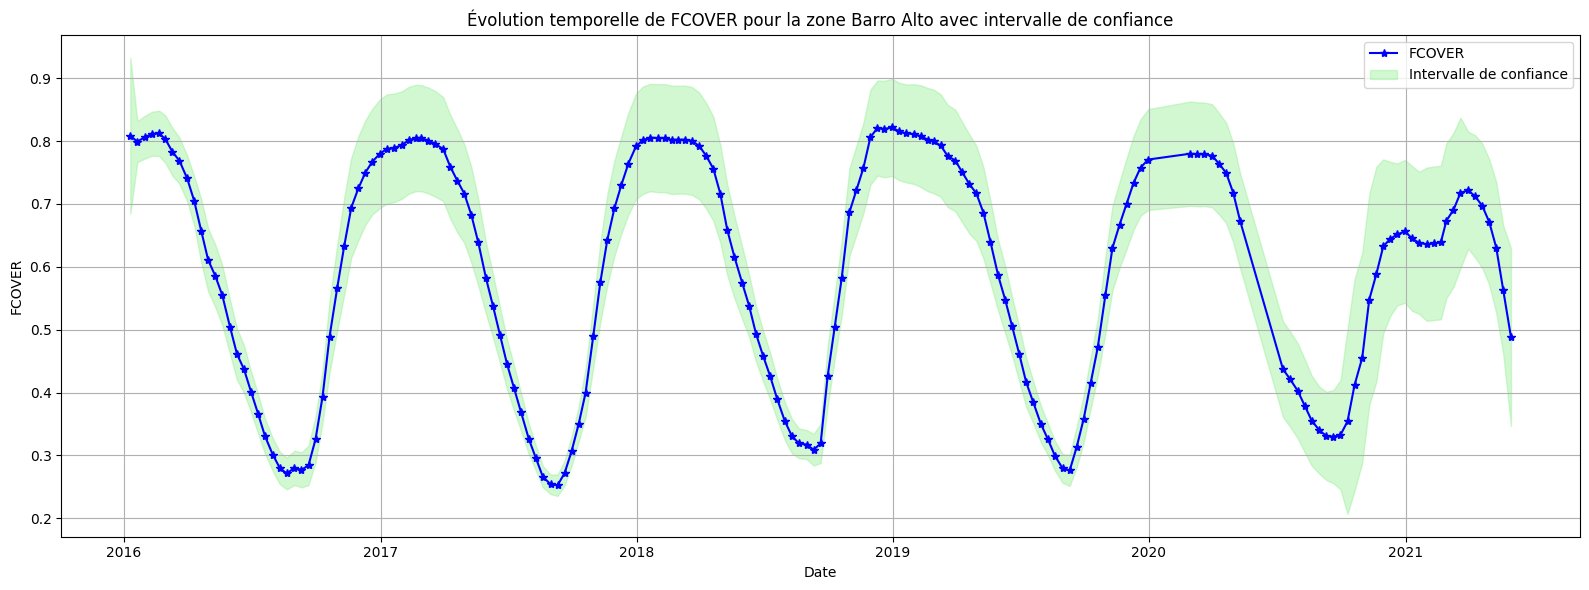

In [11]:
# Tracé de l'évolution temporelle de FCOVER avec intervalle de confiance pour la zone Barro Alto
plt.figure(figsize=(16, 6))
plt.plot(fc_df['DATE'], fc_df['FCOVER'], '*-', color='blue', label='FCOVER')
plt.fill_between(fc_df['DATE'], fc_df['FCOVER'] - fc_df['RMSE'], fc_df['FCOVER'] + fc_df['RMSE'], color='lightgreen', alpha=0.4, label='Intervalle de confiance')
plt.xlabel('Date')
plt.ylabel('FCOVER')
plt.title('Évolution temporelle de FCOVER pour la zone Barro Alto avec intervalle de confiance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### ML : régression linéaire (et autre modèles ?)

Dans cette phase, nous utiliserons la régression linéaire pour prédire la couverture végétale (FCOVER) en fonction du RVI , latitude et longitude.

On fusionne les DataFrames `fc_df` et `rvi_df` en utilisant la fonction `merge_asof`de `pandas` pour combiner les données  `FCOVER` avec les données du `RVI` dans un seul dataframe. La fusion est basée sur la colonne de date (`'DATE'`), et une tolérance de 10 jours ()`tolérance`) est utilisée pour permettre une certaine flexibilité dans l'alignement des dates entre les deux ensembles de données. On gardera les paramètres `RMSE`, `DLAT` et `DLON` pour la prédiction.

In [12]:
# Définir la tolérance de 10 jours
tolerance = pd.Timedelta(days=10)

# Fusionner les DataFrames en conservant uniquement les colonnes pertinentes
merged_df = pd.merge_asof(fc_df[['DATE', 'FCOVER', 'RMSE']], 
                          rvi_df[['DATE', 'RVI', 'RMSE', 'DLAT', 'DLON']], 
                          on='DATE', 
                          direction='nearest', 
                          tolerance=tolerance)

# Afficher les premières lignes du DataFrame combiné
print(merged_df.head())

        DATE    FCOVER    RMSE_x  RVI  RMSE_y  DLAT  DLON
0 2016-01-10  0.808591  0.124193  NaN     NaN   NaN   NaN
1 2016-01-20  0.799199  0.032586  NaN     NaN   NaN   NaN
2 2016-01-31  0.806481  0.033995  NaN     NaN   NaN   NaN
3 2016-02-10  0.811652  0.034934  NaN     NaN   NaN   NaN
4 2016-02-20  0.812406  0.036070  NaN     NaN   NaN   NaN


Nous avons supprimé les lignes contenant des valeurs NaN de`merged_df` pour nous assurer que nous travaillons uniquement avec des données complètes. Ensuite, nous avons retiré la colonne `RMSE_y`, car elle n'est plus nécessaire après la fusion. Le nombre de lignes restantes après ce nettoyage est affiché pour avoir une idée du nombre d'observations disponibles pour notre modèle.

Enfin, nous avons calculé la plage des valeurs de FCOVER (`plage_fcover`) dans le dataframe nettoyé et l'avons imprimée pour avoir une idée de la variabilité. 

In [13]:
# Supprimer les lignes contenant des valeurs NaN
merged_df_cleaned = merged_df.dropna()
merged_df_cleaned = merged_df_cleaned.drop(columns=['RMSE_y'])

# Afficher le nombre de lignes restantes
print("Nombre de lignes restantes après suppression des valeurs NaN :", merged_df_cleaned.shape[0])
print(merged_df_cleaned.head())

plage_fcover = [min(merged_df_cleaned.FCOVER),max(merged_df_cleaned.FCOVER)]
print(plage_fcover)

Nombre de lignes restantes après suppression des valeurs NaN : 65
          DATE    FCOVER    RMSE_x       RVI      DLAT      DLON
116 2019-03-31  0.769064  0.080819  2.022880  0.348049 -1.002555
117 2019-04-10  0.750123  0.079672  2.022880  0.348049 -1.002555
118 2019-04-20  0.731707  0.078728  2.022383  0.347935 -1.002663
119 2019-04-30  0.716766  0.075507  2.021148  0.347987 -1.002477
120 2019-05-10  0.686250  0.072471  2.027205  0.059503  0.987493
[0.276167715595422, 0.780015088440629]


On établit maintenant un modèle de régression linéaire pour prédire la couverture végétale `y` à partir des variables RVI, DLAT et DLON `X`. Les données sont entraînées à l'aide de scikit-learn (`LinearRegression`). L'erreur quadratique `rmse` sera notre critère de la précision du modèle.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt

# Séparation des variables indépendantes (X) et de la variable dépendante (y)
X = merged_df_cleaned[['RVI', 'DLAT', 'DLON']]
y = merged_df_cleaned['FCOVER']

# Initialisation du modèle de régression linéaire
model = LinearRegression()

# Entraînement du modèle
model.fit(X, y)

# Prédiction des valeurs de FCOVER pour toutes les données
y_pred = model.predict(X)

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse = root_mean_squared_error(y, y_pred)
print("RMSE du modèle de régression linéaire : {:.3f}".format(rmse))


RMSE du modèle de régression linéaire : 0.095


Comparaison :

Pour avoir une idée des résultats de la prédiction, on  effectue une représentation graphique du `FCOVER`. Les points bleus représentent les données réelles, les points rouges représentent les prédictions du modèle.

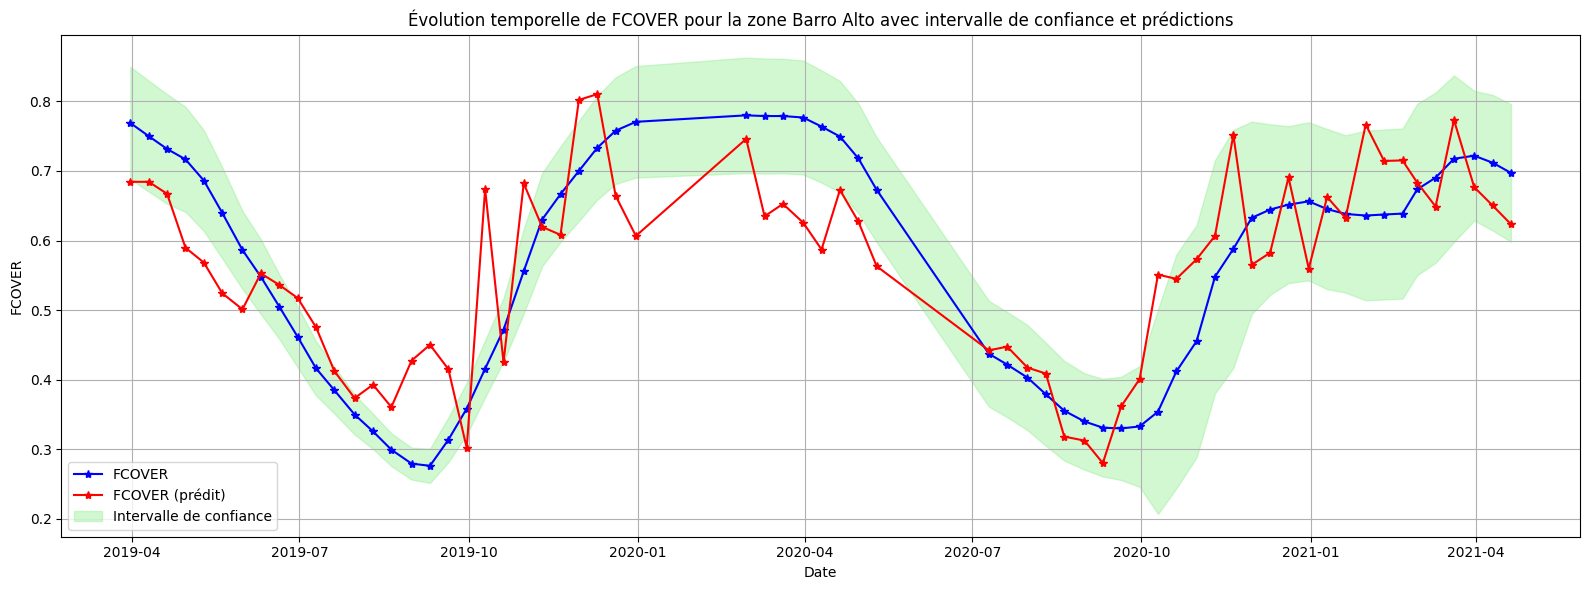

In [16]:
# Affichage du graphe
plt.figure(figsize=(16, 6))
plt.plot(merged_df_cleaned['DATE'], merged_df_cleaned['FCOVER'], '*-', color='blue', label='FCOVER')
plt.plot(merged_df_cleaned['DATE'], y_pred, '*-', color='red', label='FCOVER (prédit)')
plt.fill_between(merged_df_cleaned['DATE'], merged_df_cleaned['FCOVER'] - merged_df_cleaned['RMSE_x'], merged_df_cleaned['FCOVER'] + merged_df_cleaned['RMSE_x'], color='lightgreen', alpha=0.4, label='Intervalle de confiance')
plt.xlabel('Date')
plt.ylabel('FCOVER')
plt.title('Évolution temporelle de FCOVER pour la zone Barro Alto avec intervalle de confiance et prédictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Maintenant que nous avons obtenu les performances de la régression linéaire, nous pouvons explorer d'autres modèles pour voir s'ils offrent de meilleures performances de prédiction.

#### Régression polynomiale 

On crée un modèle de régression polynomiale de degré 5 en utilisant scikit-learn. Il combine `PolynomialFeatures`, qui génère les caractéristiques polynomiales, avec `LinearRegression` pour former le modèle. Ensuite, il entraîne le modèle avec les données d'entrée (X et y) et prédit les valeurs de FCOVER pour ces données. 

RMSE du modèle de régression polynomiale (degré 5): 0.048


/Users/yacinebenami/Desktop/MACS2/Analyse_donnees_macs2/satellite_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


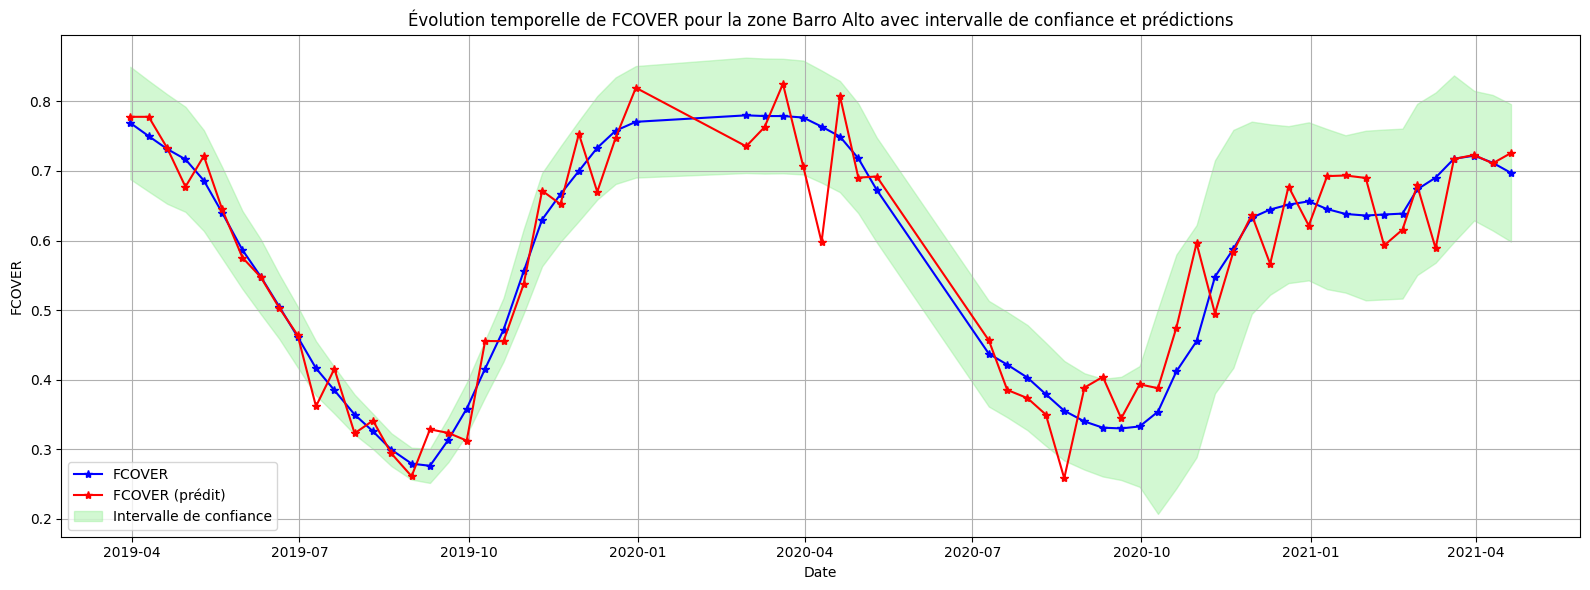

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Création d'un modèle de régression polynomiale de degré 5
degree = 5
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Entraînement du modèle
model.fit(X, y)

# Prédiction des valeurs de FCOVER pour toutes les données
y_pred_poly = model.predict(X)

# Calcul de l'erreur quadratique moyenne (RMSE)
rmse_poly = mean_squared_error(y, y_pred_poly, squared=False)
print("RMSE du modèle de régression polynomiale (degré {}): {:.3f}".format(degree, rmse_poly))

# Affichage du graphe
plt.figure(figsize=(16, 6))
plt.plot(merged_df_cleaned['DATE'], merged_df_cleaned['FCOVER'], '*-', color='blue', label='FCOVER')
plt.plot(merged_df_cleaned['DATE'], y_pred_poly, '*-', color='red', label='FCOVER (prédit)')
plt.fill_between(merged_df_cleaned['DATE'], merged_df_cleaned['FCOVER'] - merged_df_cleaned['RMSE_x'], merged_df_cleaned['FCOVER'] + merged_df_cleaned['RMSE_x'], color='lightgreen', alpha=0.4, label='Intervalle de confiance')
plt.xlabel('Date')
plt.ylabel('FCOVER')
plt.title('Évolution temporelle de FCOVER pour la zone Barro Alto avec intervalle de confiance et prédictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Le modèle polynomiale capture mieux les relations non linéaires entre les variables explicatives et la cible. Le RMSE est significativement inférieur à celui de la régression linéaire.


## Partie : Affichage RADAR

Il s'agit d'un travail similaire à celui qui a été fait sur `radar_doc.ipynb`, on extrait les images pour Barro-Alto

In [18]:
zonedir = os.path.realpath(
    os.path.join(
    os.path.dirname(sat.EARTHDIR),'..','Barro-Alto'))
print(zonedir)

/Users/yacinebenami/Desktop/MACS2/Analyse_donnees_macs2/satellite/data/zones/Barro-Alto


In [19]:
df = pd.read_csv(os.path.join(zonedir,'RVItable.csv'))
df.set_index('DATE', drop=True, inplace=True)
df.head()

,RVI,RMSE,INCIDENCE,ELEVATION,DIRECTION,DLAT,DLON,DX,DY,ZIPFILE,RVIC
DATE,,,,,,,,,,,
2019-04-08,2.022880,0.014757,45.177209,39.718881,-1,0.348049,-1.002555,11381.5,-1208.0,S1A_IW_GRDH_1SDV_20190408T084503_20190408T0845...,2.026044
2019-04-13,2.030516,0.020464,32.315486,28.789817,-1,0.059303,0.987514,-10136.0,-3043.0,S1A_IW_GRDH_1SDV_20190413T085312_20190413T0853...,2.026746
2019-04-20,2.022383,0.014615,45.171332,39.713658,-1,0.347935,-1.002663,11390.0,-1208.0,S1A_IW_GRDH_1SDV_20190420T084504_20190420T0845...,2.026234
2019-04-25,2.028855,0.018965,32.306826,28.782296,-1,0.059273,0.988726,-10146.0,-3043.0,S1A_IW_GRDH_1SDV_20190425T085313_20190425T0853...,2.026005
2019-05-02,2.021148,0.013618,45.172762,39.714986,-1,0.347987,-1.002477,11380.5,-1208.0,S1A_IW_GRDH_1SDV_20190502T084504_20190502T0845...,2.025450


In [31]:
rawdir = sat.EARTHDIR
oc = Ocli(rawdir,'mines.geojson')

zone = oc[0]
zone

{'name': 'Barro Alto - Nickel (Brésil)',
 'bbox': [np.float64(-15.120681846262826),
  np.float64(-49.064565561195195),
  np.float64(-15.03010101576109),
  np.float64(-48.93317158095951)]}

In [32]:
sat.radar.rviquery(zone)

'(footprint:"Contains(POLYGON((-49.065 -15.121,-48.933 -15.121,-48.933 -15.030,-49.065 -15.030,-49.065 -15.121)))") AND  ((platformname:Sentinel-1 AND producttype:GRD))'

In [33]:
listsafe = [froot for froot,_,_ in os.walk(zonedir)
            if froot.endswith('.SAFE')] 
safedir0 = listsafe[0]

In [34]:
import os

# Chemin vers le répertoire d'annotation
annotation_dir = os.path.join(safedir0, 'annotation')

# Lister les fichiers dans le répertoire
all_files = os.listdir(annotation_dir)
print(f"Fichiers dans le répertoire 'annotation' : {all_files}")

# Filtrer les fichiers XML
xmlfiles = [fname for fname in all_files if fname.endswith('.xml')]

# Vérification si des fichiers XML ont été trouvés
if len(xmlfiles) > 0:
    xmlfile0 = os.path.join(annotation_dir, xmlfiles[0])
    print(f"Premier fichier XML trouvé : {xmlfile0}")
else:
    print("Aucun fichier XML trouvé dans le répertoire 'annotation'.")


Fichiers dans le répertoire 'annotation' : ['calibration', 's1a-iw-grd-vv-20200419t085319-20200419t085344-032194-03b91f-001.xml', 's1a-iw-grd-vh-20200419t085319-20200419t085344-032194-03b91f-002.xml']
Premier fichier XML trouvé : /Users/yacinebenami/Desktop/MACS2/Analyse_donnees_macs2/satellite/data/zones/Barro-Alto/S1A_IW_GRDH_1SDV_20200419T085319_20200419T085344_032194_03B91F_5E0A.SAFE/annotation/s1a-iw-grd-vv-20200419t085319-20200419t085344-032194-03b91f-001.xml


In [35]:
# Liste des fichiers XML dans le répertoire
xmlfiles = [fname 
            for fname in os.listdir(os.path.join(safedir0, 'annotation'))
            if fname.endswith('.xml')]

xmlfile0 = os.path.join(safedir0,'annotation',xmlfiles[0])

In [36]:
import datetime as dt
from xml.etree import ElementTree

root = ElementTree.parse(xmlfile0)
def getxmltext(root,name):
    for e in root.iter(name):
        return e.text
    
desc = dict(
    polarisation = getxmltext(root,'polarisation'),
    date = dt.datetime.fromisoformat(getxmltext(root,'startTime')),
    direction = getxmltext(root,'pass'),
    heigth = int(getxmltext(root,'numberOfLines')),
    width = int(getxmltext(root,'numberOfSamples')))
desc

{'polarisation': 'VV',
 'date': datetime.datetime(2020, 4, 19, 8, 53, 19, 415665),
 'direction': 'Descending',
 'heigth': 16840,
 'width': 25871}

In [37]:
M = [(int(e.find('line').text),int(e.find('pixel').text),
        float(e.find('latitude').text), float(e.find('longitude').text),
        float(e.find('incidenceAngle').text),
        float(e.find('elevationAngle').text) 
        )
        for e in root.iter('geolocationGridPoint')]
code = pd.DataFrame(M,columns=['line','pixel','lat','lon',
                                'incidence','elevation'])
code

,line,pixel,lat,lon,incidence,elevation
0,0,0,-14.645167,-48.628115,30.430134,27.149879
1,0,1294,-14.619108,-48.743486,31.322696,27.927799
2,0,2588,-14.593574,-48.856282,32.175157,28.668150
3,0,3882,-14.567131,-48.972786,33.051617,29.428789
4,0,5176,-14.540511,-49.089787,33.919405,30.180231
...,...,...,...,...,...,...
205,16839,20704,-15.719237,-50.857158,43.195004,38.067608
206,16839,21998,-15.691439,-50.974897,43.894286,38.650171
207,16839,23292,-15.663636,-51.092362,44.578934,39.218342
208,16839,24586,-15.635801,-51.209669,45.250341,39.773396


In [38]:
mask = sat.radar.getllmask(zone,desc,code)
mask

{'bbox': (2040, 4795, 3685, 6115),
 'incidence': np.float64(32.37352535041269),
 'elevation': np.float64(28.8408761745211),
 'dvec': (np.float64(0.054447225950477574), np.float64(0.9781792760791248)),
 'dxy': (-10073.0, -2965.0),
 'lat': array([[-15.0326675 , -15.03264686, -15.03262621, ..., -14.99944391,
         -14.9994243 , -14.99940468],
        [-15.03275765, -15.03273701, -15.03271636, ..., -14.99953346,
         -14.99951384, -14.99949423],
        [-15.0328478 , -15.03282716, -15.03280651, ..., -14.999623  ,
         -14.99960339, -14.99958378],
        ...,
        [-15.1511354 , -15.15111514, -15.15109488, ..., -15.11754651,
         -15.11752595, -15.1175054 ],
        [-15.15122454, -15.15120428, -15.15118402, ..., -15.11763565,
         -15.11761509, -15.11759454],
        [-15.15131368, -15.15129342, -15.15127316, ..., -15.11772479,
         -15.11770424, -15.11768368]]),
 'lon': array([[-48.91291153, -48.91300263, -48.91309372, ..., -49.05928011,
         -49.05936648, 

In [39]:
tiffile0 = os.path.join(safedir0, 'measurement', xmlfiles[0][:-4]+'.tiff')
tiffile0

'/Users/yacinebenami/Desktop/MACS2/Analyse_donnees_macs2/satellite/data/zones/Barro-Alto/S1A_IW_GRDH_1SDV_20200419T085319_20200419T085344_032194_03B91F_5E0A.SAFE/measurement/s1a-iw-grd-vv-20200419t085319-20200419t085344-032194-03b91f-001.tiff'

In [45]:
from osgeo import gdal

ds = gdal.Open(tiffile0,gdal.GA_ReadOnly)
band = ds.GetRasterBand(1)
minx,miny,maxx,maxy = mask['bbox'] 
img = band.ReadAsArray(minx,miny,maxx-minx,maxy-miny)
img

/Users/yacinebenami/Desktop/MACS2/Analyse_donnees_macs2/satellite_env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


array([[188, 159, 172, ..., 162, 130, 159],
       [196, 192, 185, ..., 174, 181, 189],
       [200, 198, 181, ..., 224, 236, 222],
       ...,
       [247, 311, 415, ..., 271, 244, 253],
       [329, 259, 290, ..., 224, 259, 294],
       [397, 293, 196, ..., 187, 215, 259]], dtype=uint16)

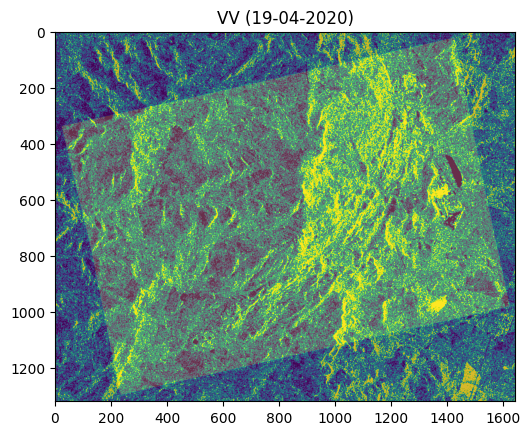

In [46]:
fimg = sat.radar.imgnorm(img,.1)
f = plt.imshow(fimg[:,::-1])
ax = f.axes
        
belong = mask['belong']
ax.imshow(belong[:,::-1], alpha=0.2)
ax.set_title(desc['polarisation'] + 
             ' (' + dt.datetime.strftime(desc['date'],"%d-%m-%Y") +')',
             fontsize=12);

In [47]:
tiffile1 = os.path.join(safedir0, 'measurement', xmlfiles[1][:-4]+'.tiff')

In [48]:
ds = gdal.Open(tiffile1,gdal.GA_ReadOnly)
band = ds.GetRasterBand(1)

minx,miny,maxx,maxy = mask['bbox'] 
img_1 = band.ReadAsArray(minx,miny,maxx-minx,maxy-miny)
img_1

array([[ 83,  73,  92, ...,  79,  88, 100],
       [117, 137, 126, ...,  78,  74, 119],
       [165, 198, 174, ...,  86, 103, 117],
       ...,
       [150, 113,  83, ..., 117, 108, 115],
       [146, 114,  71, ..., 126, 140, 147],
       [137,  96,  75, ..., 160, 198, 195]], dtype=uint16)

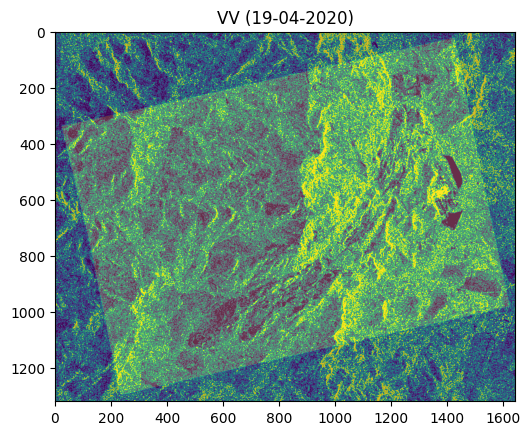

In [49]:
fimg = sat.radar.imgnorm(img_1,.1)
f = plt.imshow(fimg[:,::-1])
ax = f.axes
        
belong = mask['belong']
ax.imshow(belong[:,::-1], alpha=0.2)
ax.set_title('VV'+ 
             ' (' + dt.datetime.strftime(desc['date'],"%d-%m-%Y") +')',
             fontsize=12);

In [50]:
img_2 = (4 * img)/(img_1 + img)
img_2

array([[2.77490775, 2.74137931, 2.60606061, ..., 2.68879668, 2.3853211 ,
        2.45559846],
       [2.50479233, 2.3343465 , 2.37942122, ..., 2.76190476, 2.83921569,
        2.45454545],
       [2.19178082, 2.        , 2.03943662, ..., 2.89032258, 2.78466077,
        2.61946903],
       ...,
       [2.48866499, 2.93396226, 3.33333333, ..., 2.79381443, 2.77272727,
        2.75      ],
       [2.77052632, 2.77747989, 3.2132964 , ..., 2.56      , 2.59649123,
        2.66666667],
       [2.97378277, 3.01285347, 2.89298893, ..., 2.1556196 , 2.08232446,
        2.28193833]])

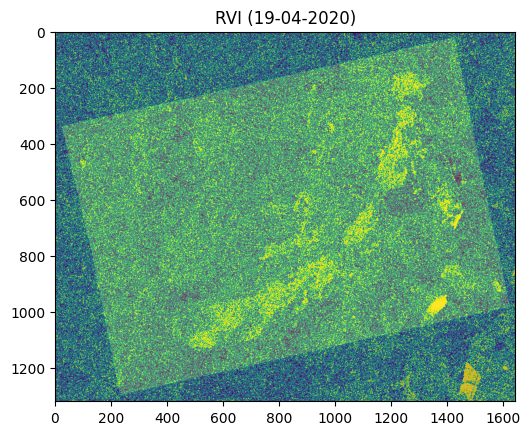

In [51]:
fimg = sat.radar.imgnorm(img_2,.1)
f = plt.imshow(fimg[:,::-1])
ax = f.axes
        
belong = mask['belong']
ax.imshow(belong[:,::-1], alpha=0.2)
ax.set_title('RVI'+ 
             ' (' + dt.datetime.strftime(desc['date'],"%d-%m-%Y") +')',
             fontsize=12);

### FIN